In [1]:
%matplotlib inline
import tqdm
import collections
import sys
import os
import glob
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import time
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.model_selection import train_test_split
from behavior_utils import determineK,behavior_pca,gmm_plt,behavior_tsne,cluster_visual

# Import files

In [3]:
#Set up base directory and file names
base=r'/Users/sky/Desktop/VIP'
files = ['ALC_050319_1_41B_OF_aligned','ALC_050319_1_41B_aligned','ALC_050319_1_41C_aligned',
         'ALC_050319_1_41R_aligned','ALC_050319_1_42B_aligned','ALC_050319_1_42C_aligned',
         'ALC_050319_1_42R_aligned','ALC_050319_1_43B_aligned','ALC_050319_1_43C_aligned',
         'ALC_050319_1_43G_aligned','ALC_050319_1_43R_aligned','ALC_050319_2_44B_aligned',
         'ALC_050319_2_44C_aligned','ALC_050319_2_44R_aligned','ALC_050319_2_45B_aligned',
         'ALC_050319_2_45R_aligned','ALC_050319_2_46B_aligned','ALC_050319_2_46C_aligned',
         'ALC_050319_2_46R_aligned','ALC_051719_1_42Bk_aligned','ALC_051719_1_42G_aligned',
         'ALC_051719_1_45Bk_aligned','ALC_051719_1_45C_aligned','ALC_051719_2_53B_aligned',
         'ALC_051719_2_53C_aligned','ALC_051719_2_53G_aligned','ALC_051719_2_53R_aligned',
         'ALC_051719_2_54B_aligned','ALC_051719_2_54C_aligned',
         'ALC_051719_2_54R_aligned','ALC_051719_2_55B_aligned','ALC_051719_2_55C_aligned',
         'ALC_051719_2_55R_aligned','ALC_060519_1_49B_aligned','ALC_060519_1_49C_aligned',
         'ALC_060519_1_49R_aligned','ALC_060519_2_48B_aligned','ALC_060519_2_48C_aligned',
         'ALC_060519_2_48R_aligned','ALC_060519_2_57B_aligned','ALC_060519_2_57C_aligned',
         'ALC_060519_2_57G_aligned','ALC_060519_2_57R_aligned','ALC_060519_2_58B_aligned',
         'ALC_060519_2_58C_aligned','ALC_060519_2_58R_aligned','ALC_070519_1_21B_aligned',
         'ALC_070519_1_21C_aligned','ALC_070519_1_21R_aligned','ALC_070519_1_31B_aligned',
         'ALC_070519_1_31C_aligned','ALC_070519_1_31R_aligned','ALC_070519_1_60B_aligned',
         'ALC_070519_1_60C_aligned','ALC_070519_1_60G_aligned','ALC_070519_1_60R_aligned']

In [24]:
#Read files
start_time = time.time()


files = glob.glob(os.path.join(base,"*.analysis"))

dataframes = (pd.read_pickle(f).assign(trial=f[f.find('ALC_') + 4:f.find('_aligned', f.find('ALC_') + 4)]) for f in files)
big_dataframe = pd.concat(dataframes, ignore_index=False)

print("---Read data: %s seconds ---" % (time.time() - start_time))

big_dataframe = big_dataframe.reset_index()

---Read data: 0.7183260917663574 seconds ---


## Organize data

In [25]:
# rename columns
big_dataframe = big_dataframe.rename(columns={big_dataframe.columns[1]: 'raw_centroid_x',big_dataframe.columns[2]: 'raw_centroid_y',
                             big_dataframe.columns[4]: 'centroid_x',big_dataframe.columns[5]: 'centroid_y',
                             big_dataframe.columns[6]: 'snout_x',big_dataframe.columns[7]: 'snout_y',
                             big_dataframe.columns[8]: 'tail_base_x',big_dataframe.columns[9]: 'tail_base_y',
                             big_dataframe.columns[10]: 'l_ear_x',big_dataframe.columns[11]: 'l_ear_y',
                             big_dataframe.columns[12]: 'r_ear_x',big_dataframe.columns[13]: 'r_ear_y'})

## Create features

In [26]:
# create distances between every two points

big_dataframe['centroid_snout'] = big_dataframe.apply(lambda col: 
                                                      math.sqrt( ((col['centroid_x']-col['snout_x'])**2)+((col['centroid_y']-col['snout_y'])**2) ), axis=1)
big_dataframe['centroid_tail'] = big_dataframe.apply(lambda col: 
                                                      math.sqrt( ((col['centroid_x']-col['tail_base_x'])**2)+((col['centroid_y']-col['tail_base_y'])**2) ), axis=1)
big_dataframe['centroid_lear'] = big_dataframe.apply(lambda col: 
                                                      math.sqrt( ((col['centroid_x']-col['l_ear_x'])**2)+((col['centroid_y']-col['l_ear_y'])**2) ), axis=1)
big_dataframe['centroid_rear'] = big_dataframe.apply(lambda col: 
                                                      math.sqrt( ((col['centroid_x']-col['r_ear_x'])**2)+((col['centroid_y']-col['r_ear_y'])**2) ), axis=1)

big_dataframe['snout_tail'] = big_dataframe.apply(lambda col: 
                                                      math.sqrt( ((col['snout_x']-col['tail_base_x'])**2)+((col['snout_y']-col['tail_base_y'])**2) ), axis=1)
big_dataframe['snout_lear'] = big_dataframe.apply(lambda col: 
                                                      math.sqrt( ((col['snout_x']-col['l_ear_x'])**2)+((col['snout_y']-col['l_ear_y'])**2) ), axis=1)
big_dataframe['snout_rear'] = big_dataframe.apply(lambda col: 
                                                      math.sqrt( ((col['snout_x']-col['r_ear_x'])**2)+((col['snout_y']-col['r_ear_y'])**2) ), axis=1)

big_dataframe['tail_lear'] = big_dataframe.apply(lambda col: 
                                                      math.sqrt( ((col['tail_base_x']-col['l_ear_x'])**2)+((col['tail_base_y']-col['l_ear_y'])**2) ), axis=1)
big_dataframe['tail_rear'] = big_dataframe.apply(lambda col: 
                                                      math.sqrt( ((col['tail_base_x']-col['r_ear_x'])**2)+((col['tail_base_y']-col['r_ear_y'])**2) ), axis=1)

big_dataframe['lear_rear'] = big_dataframe.apply(lambda col: 
                                                      math.sqrt( ((col['l_ear_x']-col['r_ear_x'])**2)+((col['l_ear_y']-col['r_ear_y'])**2) ), axis=1)





In [27]:
# Compute average distance b/t ears for each mouse (ignoring NaN)
avg_betears = big_dataframe.groupby('trial')['lear_rear'].agg(np.nanmean)
big_dataframe = big_dataframe.merge(avg_betears, on='trial',suffixes=('', '_mean'))


In [28]:
# Create standardized distances
big_dataframe['sd_centroid_snout'] = big_dataframe.apply(lambda col: 
                                                      col['centroid_snout']/col['lear_rear_mean'], axis=1)
big_dataframe['sd_centroid_tail'] = big_dataframe.apply(lambda col: 
                                                      col['centroid_tail']/col['lear_rear_mean'], axis=1)
big_dataframe['sd_centroid_lear'] = big_dataframe.apply(lambda col: 
                                                      col['centroid_lear']/col['lear_rear_mean'], axis=1)
big_dataframe['sd_centroid_rear'] = big_dataframe.apply(lambda col: 
                                                      col['centroid_rear']/col['lear_rear_mean'], axis=1)
big_dataframe['sd_snout_tail'] = big_dataframe.apply(lambda col: 
                                                      col['snout_tail']/col['lear_rear_mean'], axis=1)
big_dataframe['sd_snout_lear'] = big_dataframe.apply(lambda col: 
                                                      col['snout_lear']/col['lear_rear_mean'], axis=1)
big_dataframe['sd_snout_rear'] = big_dataframe.apply(lambda col: 
                                                      col['snout_rear']/col['lear_rear_mean'], axis=1)
big_dataframe['sd_tail_lear'] = big_dataframe.apply(lambda col: 
                                                      col['tail_lear']/col['lear_rear_mean'], axis=1)
big_dataframe['sd_tail_rear'] = big_dataframe.apply(lambda col: 
                                                      col['tail_rear']/col['lear_rear_mean'], axis=1)
big_dataframe['sd_lear_rear'] = big_dataframe.apply(lambda col: 
                                                      col['lear_rear']/col['lear_rear_mean'], axis=1)



In [29]:
# create instantaneous velocity 
x1 = np.array(big_dataframe["raw_centroid_x"])
y1= np.array(big_dataframe["raw_centroid_y"])

x2 = x1[1:]
x1 = x1[:-1]
y2 = y1[1:]
y1 = y1[:-1]

v = np.sqrt(np.power(x1-x2,2) + np.power(y1-y2,2))
big_dataframe['velocity'] = np.append([0],v)


# filter value frames (discard 1st frame of each trial)
big_dataframe['lastindex'] = big_dataframe['index'].shift(1)
big_dataframe = big_dataframe.iloc[np.where(big_dataframe['index']>big_dataframe['lastindex'])]

In [30]:
# create history records (8 frames prior)
# history records include: index, raw centroid x y coordinates, standardized distances b/t points, velosity
hist1 = big_dataframe.iloc[:, [0,1,2,26,27,28,29,30,31,32,33,34,35,36]].shift(1)
hist1.columns += '_hist1'

hist2 = big_dataframe.iloc[:, [0,1,2,26,27,28,29,30,31,32,33,34,35,36]].shift(2)
hist2.columns += '_hist2'

hist3 = big_dataframe.iloc[:, [0,1,2,26,27,28,29,30,31,32,33,34,35,36]].shift(3)
hist3.columns += '_hist3'

hist4 = big_dataframe.iloc[:, [0,1,2,26,27,28,29,30,31,32,33,34,35,36]].shift(4)
hist4.columns += '_hist4'

hist5 = big_dataframe.iloc[:, [0,1,2,26,27,28,29,30,31,32,33,34,35,36]].shift(5)
hist5.columns += '_hist5'

hist6 = big_dataframe.iloc[:, [0,1,2,26,27,28,29,30,31,32,33,34,35,36]].shift(6)
hist6.columns += '_hist6'

hist7 = big_dataframe.iloc[:, [0,1,2,26,27,28,29,30,31,32,33,34,35,36]].shift(7)
hist7.columns += '_hist7'

hist8 = big_dataframe.iloc[:, [0,1,2,26,27,28,29,30,31,32,33,34,35,36]].shift(8)
hist8.columns += '_hist8'

big_dataframe = pd.concat([big_dataframe, hist1,hist2,hist3,hist4,hist5,hist6,hist7,hist8], axis=1)

In [52]:
big_dataframe.iloc[17590:18170,np.r_[123:136]]

,raw_centroid_x_hist7,raw_centroid_y_hist7,sd_centroid_snout_hist7,sd_centroid_tail_hist7,sd_centroid_lear_hist7,sd_centroid_rear_hist7,sd_snout_tail_hist7,sd_snout_lear_hist7,sd_snout_rear_hist7,sd_tail_lear_hist7,sd_tail_rear_hist7,sd_lear_rear_hist7,velocity_hist7
19035,64.034667,53.621717,2.265065,1.092994,1.011822,1.100855,3.162991,1.905144,1.453213,2.087844,1.752377,1.476222,1.665632
19036,63.929564,54.511769,2.452224,1.379156,1.122103,1.094370,3.518523,1.781201,1.694533,2.496833,1.837450,1.393387,0.896237
19037,64.216861,54.014467,2.518227,1.404030,1.336227,1.155425,3.572755,1.344410,1.646750,2.641474,1.932336,1.095720,0.574325
19038,64.954854,54.797445,2.662385,1.465505,1.493636,1.286015,3.892659,1.454529,1.576361,2.931713,2.326950,1.169080,1.075959
19039,64.648249,56.229303,2.932746,1.519518,1.685574,1.530465,4.243037,1.450463,1.652745,3.165350,2.626746,1.187509,1.464317
19040,66.251786,56.734167,3.042268,1.511215,1.822655,1.668945,4.387567,1.412339,1.608473,3.303278,2.829194,1.169151,1.681136
19041,68.700195,54.249660,3.022467,1.636405,1.829972,1.728932,4.455077,1.376031,1.479815,3.419493,3.001817,1.070896,3.488192
19042,70.743158,53.324526,3.169031,1.638177,1.990562,1.973462,4.656228,1.278832,1.425537,3.579099,3.298724,0.999593,2.242671
19043,73.169016,51.505284,3.136583,1.758015,2.114547,2.096031,4.758536,1.077639,1.300140,3.810442,3.553574,0.914868,3.032232
19044,77.278600,50.304002,3.116182,1.899364,2.121237,2.163442,4.918085,1.102338,1.193341,3.995846,3.827933,0.982875,4.281560


In [33]:
big_dataframe = big_dataframe.dropna()
big_dataframe = big_dataframe.iloc[np.where(big_dataframe['index']>big_dataframe['index_hist8'])]

In [35]:
big_dataframe.isnull().sum()

index                      0
raw_centroid_x             0
raw_centroid_y             0
angle_from_veridical       0
centroid_x                 0
centroid_y                 0
snout_x                    0
snout_y                    0
tail_base_x                0
tail_base_y                0
l_ear_x                    0
l_ear_y                    0
r_ear_x                    0
r_ear_y                    0
trial                      0
centroid_snout             0
centroid_tail              0
centroid_lear              0
centroid_rear              0
snout_tail                 0
snout_lear                 0
snout_rear                 0
tail_lear                  0
tail_rear                  0
lear_rear                  0
lear_rear_mean             0
sd_centroid_snout          0
sd_centroid_tail           0
sd_centroid_lear           0
sd_centroid_rear           0
                          ..
sd_lear_rear_hist6         0
velocity_hist6             0
index_hist7                0
raw_centroid_x

In [36]:
big_dataframe.to_pickle('Behavior_data0428.pkl')

In [2]:
#big_dataframe=pd.read_pickle('Behavior_data0428.pkl')

# Clutering

## Determine k

In [3]:
# Select features
df = big_dataframe.iloc[:, np.r_[26:37,39:52,53:66,67:80,81:94,95:108,109:122,123:136,137:150]].values

df_train, df_test = train_test_split(df, test_size=0.95)

 47%|████▋     | 7/15 [02:55<04:11, 31.50s/it]/Users/sky/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
 67%|██████▋   | 10/15 [06:04<04:12, 50.54s/it]/Users/sky/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
 80%|████████  | 12/15 [09:18<03:39, 73.28s/it]/Users/sky/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
 87%|████████▋ | 13/15 [11:15<02:53, 86.65s/it]/Users/sky/anaconda3/lib/python3.7/site-packa

---GMM determine k: 930.663614988327 seconds ---


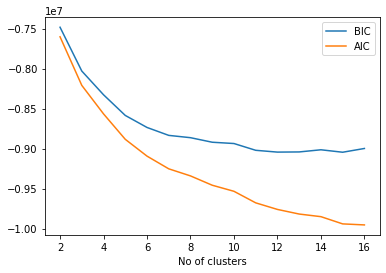

In [56]:
determineK('GMM',df_train,2,17)

## PCA 

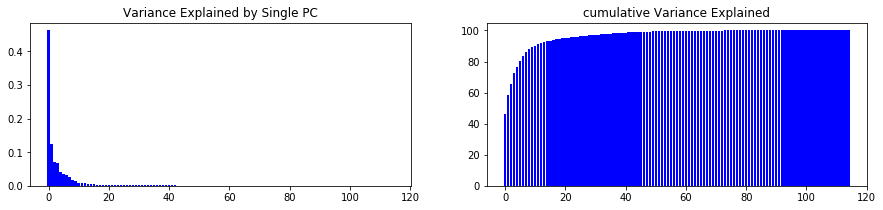

In [5]:
var2,pc2 = behavior_pca(df,1)

In [98]:
# gmm clustering
# input: data = dataset, k = no of clusters, plt = 2 or 3 dims of cluster plot
# output: an array of cluster labels
def gmm_pt(tr_d,te_d,k,dim):
    gmm = GaussianMixture(n_components=k)
    gmm.fit(tr_d)
    labels = gmm.predict(te_d)
    if (dim==2):
        plt.scatter(te_d[:, 0], te_d[:, 1], c=labels, s=1,alpha=0.1,cmap='rainbow')
        plt.title('GMM Clustering in 2 Dimensions')
    elif (dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(te_d[:, 0], te_d[:, 1], te_d[:, 2], c=labels,s=1,alpha=0.1, cmap='rainbow')
        plt.title('GMM Clustering with 3 Dimensions')
    
    return labels

## TSNE

In [119]:
sample_tsne = big_dataframe.sample(50000).iloc[:, np.r_[26:37,39:52,53:66,67:80,81:94,95:108,109:122,123:136,137:150]].values
tsne2 = behavior_tsne(sample_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.282s...
[t-SNE] Computed neighbors for 50000 samples in 23.310s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for s

## GMM

In [6]:
pc2_train,pc2_test= train_test_split(pc2, test_size=0.95)
pc2_train_12 = pc2_train.iloc[:, 0:12].values
pc2_12 = pc2.iloc[:, 0:12].values

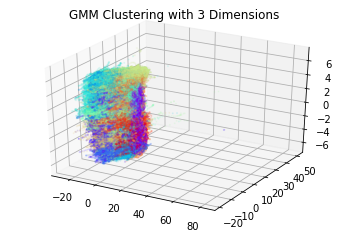

In [7]:
labels2 = gmm_plt(pc2_train_12,pc2_12,15,3)

## Skeleton Plot

In [8]:
big_dataframe_his = big_dataframe
big_dataframe_his['Pred'] = labels2

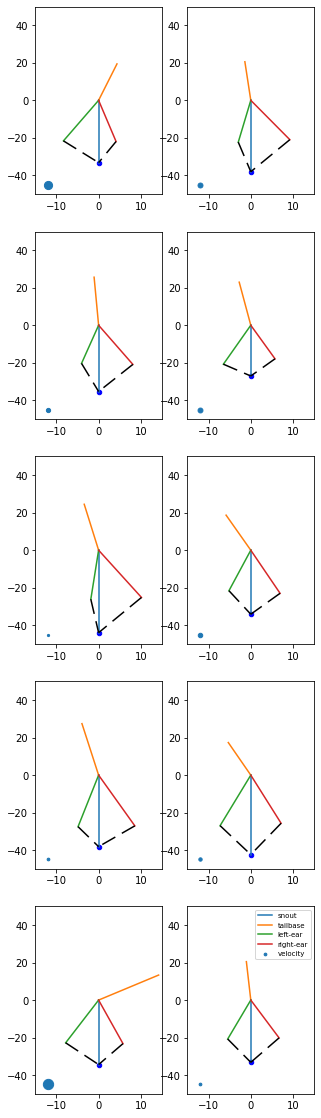

In [43]:
cluster_visual(big_dataframe_his,13)

# Analyze behaviors
## Behavior length

In [37]:
behavior_switch = big_dataframe_his.iloc[:,[0,14,-1]]

In [38]:
# determine if behavior switches
m = behavior_switch['Pred']+1
behavior_switch.loc[:,'phasecount']= np.where(m, behavior_switch.groupby(m.ne(m.shift()).cumsum()).cumcount()+1, 0)

In [39]:
behavior_length = behavior_switch[behavior_switch.Pred.ne(behavior_switch.Pred.shift(-1))]
behavior_length = behavior_length.rename({"phasecount":"framecount"}, axis='columns') 
avg_beh_length = pd.DataFrame(behavior_length.groupby(["Pred"])['framecount'].mean())

In [40]:
avg_beh_length

,framecount
Pred,
0,8.265653
1,6.169899
2,25.985570
3,14.752376
4,8.749071
5,9.745926
6,6.249117
7,23.714447
8,5.713958
